# 3 Retrieval of data from postgresql - continued

Builds on the previous notebook - more data retrieval options

In [2]:
# the following two lines indicate that external functions are auto-reloaded as soon as they change. 
%load_ext autoreload
%autoreload 2
# Print statements 
from __future__ import print_function # Python 2.x

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# General stuff:
import sys
import argparse
import os
import json
import numpy as np
import math
import psycopg2
import cPickle
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm_notebook

# Plotting:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib as mpl
%matplotlib inline

# External functions from subfolder /database_helpers. 
# as soon as you change something in there and press save, it will auto reload on next execution.
from database_helpers.psql_start import *
from database_helpers.create_tables import *
from database_helpers.write2tables import *

# register pickle type to retrieve binary data from database
psycopg2.extensions.register_type(psycopg2.extensions.new_type(psycopg2.BINARY.values, 'BINARY-PICKLE', cast_pickle))

Loaded analysis helpers: General


Try a first handshake with the database via the function `test_connect()`

In [15]:
db_status = test_connect()
if db_status == False:
    print('Grrr... no database connection could be established.')
else:
    print('Yippiyeah! Database connection is established!')

Connecting to the PostgreSQL database...
Yippiyeah! Database connection is established!


In [5]:
# load the parameters to connect to data_1 
params = config()

### More filtering ...

Let's have a look at more sql query strings

In [21]:
%%time
sql = "SELECT * FROM spiketimes_tracking_tb WHERE session_name LIKE '%obj%' LIMIT 10"
sql_db_pd = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None,parse_dates=['session_ts','analysis_ts'])

Wall time: 292 ms


The statement above should have retrieved a dataframe comprising a **maximum of 4 entries** from the **`spiketimes_tracking_tb`** (which holds the spiketimes and corresponding tracking info for every unit), but only **WHERE** the column named **session_name** has a string with something like **obj** in it. So this retrieves some object tracking examples for us - let's inspect it:

sql_db_pd.head(3)

The **limit** statement is actually very useful, if you are not 100% sure what you will get - this will keep the transaction times short (mainly the network transfer time between the database server and this computer). The **LIKE** statement can be transferred into **NOT LIKE** - to filter for strings. It is important to note that this filtering could have been done later as well - by just retrieving everything and then filtering the pandas dataframe for that string. But in this case it is far more useful - and things can speed up quite a lot using it this way.

If you aren't sure what the column names are that you got, type **.columns** to get an overview

In [24]:
sql_db_pd.columns

Index([u'cluster_no', u'analysis_ts', u'tetrode_no', u'session_name',
       u'filename', u'n_drive_user', u'animal_id', u'session_ts',
       u'spiket_tracking_session', u'spike_no', u'mean_freq'],
      dtype='object')

Sometimes it might be desirable to retrieve just a subset of the columns, not everything. Maybe you just want the gridscore but not the autocorrelation map from the `autocorr_gs_tb`. Let's do that: 

In [27]:
%%time
sql = "SELECT tetrode_no, cluster_no, session_name, session_ts, grid_score FROM autocorr_gs_tb LIMIT 10"
sql_db_pd = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None,parse_dates=['session_ts'])

Wall time: 31 ms


Now we got a "customized" dataset back, which holds only the columns that we wanted. For that we just replaced the (\*) with the specific column names of that table that we want.

In [29]:
sql_db_pd.head()

,tetrode_no,cluster_no,session_name,session_ts,grid_score
0,5,29,15042017laser4(60mW)s1,2017-04-15 16:11:31,-0.601651
1,5,4,15042017laserSess2(80mw),2017-04-16 15:09:34,-0.760008
2,5,24,17042017laserSess1(20mw),2017-04-17 14:14:48,0.486186
3,5,41,17042017s1,2017-04-17 16:05:47,0.137598
4,6,10,18042017laserSess1(60mw),2017-04-18 10:41:47,0.160277


### What about binary data?

Some data in the database is stored as binary data, meaning that it holds complex stuff, like arrays or matrices, more complex at least than simple numbers or strings. Most of it comes back as either a dataframe object (yes, so that's a dataframe within a dataframe) or a numpy array. Let's see an example.

In [38]:
%%time
sql = "SELECT * FROM ratemaps_tb LIMIT 10"
sql_db_pd = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None,parse_dates=['session_ts','analysis_ts'])

Wall time: 64 ms


In [39]:
sql_db_pd.head(1)

,cluster_no,analysis_ts,tetrode_no,session_name,filename,n_drive_user,animal_id,session_ts,nbins,xedges,yedges,masked_ratemap,calc,bin_size,sigma_rate,sigma_time,box_size_cm,speed_cutoff
0,33,2017-04-16 07:04:38.461,5,15042017s1,N:/horsto/70645/15042017/KLUSTA/0.kwik,horsto,70645,2017-04-15 16:11:31,40,"[132.334260863, 142.100417673, 151.866574484, ...","[65.4429323711, 75.4375738771, 85.432215383, 9...","[[--, 0.0393983376082, 0.0464204061083, 0.0548...",True,2.0,2.0,2.0,80.0,5.0


As you can see, when you scroll to the right, there is a column named **masked_ratemap** in the dataframe. It holds the ratemap for that specific cell/session as a masked numpy array. Retrieving it from within the dataframe is very simple - you just point to it and do with it what you want - let's plot it! 

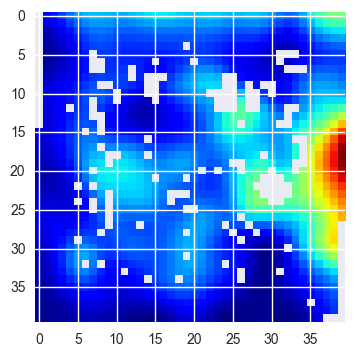

In [41]:
plt.imshow(sql_db_pd.masked_ratemap[0], cmap=cm.jet, interpolation='nearest')
# We retrieve it by pointing to the column (masked_ratemap), then selecting the first entry ([0]) 

This was an example for a numpy array, let's see what happens with dataframes within dataframes - which is even nicer. For that we will retrieve some LFP data. 

In [44]:
%%time
sql = "SELECT * FROM lfp_tb LIMIT 1"
sql_db_pd = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None,parse_dates=['session_ts','analysis_ts'])

Wall time: 2.56 s


In [45]:
sql_db_pd.head()

,analysis_ts,session_name,n_drive_user,animal_id,session_ts,lfp_session,theta_freq
0,2017-04-04 06:39:17.062,11102016s1,horsto,57837,2016-10-11 15:53:29,time eeg0 eeg1 eeg2 eeg3 eeg_...,7.766667


The interesting entries are in column **lfp_session**, which holds (sub-)dataframes with LFP data. Let's see what we get when we point specifically to it:

In [48]:
sql_db_pd.lfp_session[0].head() # get the first entry from lfp_session and display only the top

,time,eeg0,eeg1,eeg2,eeg3,eeg_mean,speed
0,0.000,0,0,0,0,0.00,3.550345
1,0.004,0,0,0,0,0.00,3.550345
2,0.008,-44,-45,-44,-44,-44.25,3.550345
3,0.012,-4,-4,-4,-5,-4.25,3.550345
4,0.016,-7,-7,-6,-7,-6.75,3.550345


This is quite nice: Now we have another dataframe that we retrieved from within the main dataframe (our lfp_tb query), which holds raw LFP data. Let's plot a snippet of that.

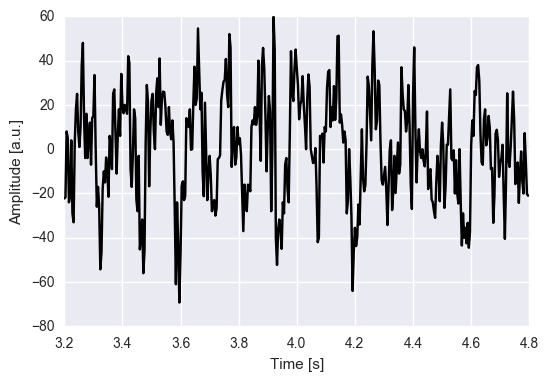

In [60]:
lfp_sample = sql_db_pd.lfp_session[0] # get a handle on it ... 
plt.plot(lfp_sample.time[800:1200],lfp_sample.eeg_mean[800:1200], color='k') # plot a tiny snippet of that data
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [a.u.]')

Let's get to some more complicated operations next ... 